In [44]:
import sys
!{sys.executable} -m pip install xgboost

In [29]:
import sys
!{sys.executable} -m pip install scikit-optimize

  Using cached scikit_optimize-0.7.4-py2.py3-none-any.whl (80 kB)
  Using cached pyaml-20.4.0-py2.py3-none-any.whl (17 kB)
  Using cached PyYAML-5.3.1-cp37-cp37m-win_amd64.whl (216 kB)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
import xgboost 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import preprocessing
from functools import partial
from skopt import space
from skopt import gp_minimize
from hyperopt import hp,fmin,tpe,Trials
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import pickle

In [2]:
if __name__ == "__main__":
    X_train = np.loadtxt(open("X_train.csv","rb"),delimiter=",")
    X_test = np.loadtxt(open("X_test.csv","rb"),delimiter=",")
    labels = pd.read_csv("Training set labels.csv")
    submission_fr = pd.read_csv("SubmissionFormat.csv")
    
    y_train = labels.status_group.values

**Creating some baseline model without any kind hyperparameter tuning that predicts only one class**

In [5]:
class BaslineModel(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return ['functional'] * len(X)

In [7]:
models = { "Waste Model" : BaslineModel(),
           "SGD Classifier" : SGDClassifier(),
           "Knn Classifier" : KNeighborsClassifier(),
           "Decision Tree Classifier" : DecisionTreeClassifier(),
           "Random Forest Classifier" : RandomForestClassifier(),
           "Ada Boost Classifier" : AdaBoostClassifier(algorithm="SAMME.R"),
           "Softmax Classifier" : LogisticRegression(multi_class="multinomial",solver="lbfgs"),
           "Gradient Boost Classifier" : GradientBoostingClassifier()
}

cv = StratifiedKFold(n_splits=10)
results = []
names = []

for key,value in models.items():
    cv_scores = cross_val_score(estimator=value,X=X_train,y=y_train,cv = cv, n_jobs=1,scoring='accuracy')
    
    results.append(cv_scores)
    names.append(key)
    
    print(key)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('----------------')

Waste Model
CV accuracy: 0.543 +/- 0.000
----------------
SGD Classifier
CV accuracy: 0.731 +/- 0.006
----------------
Knn Classifier
CV accuracy: 0.777 +/- 0.005
----------------
Decision Tree Classifier
CV accuracy: 0.727 +/- 0.005
----------------
Random Forest Classifier
CV accuracy: 0.781 +/- 0.007
----------------
Ada Boost Classifier
CV accuracy: 0.697 +/- 0.004
----------------
Softmax Classifier
CV accuracy: 0.736 +/- 0.007
----------------
Gradient Boost Classifier
CV accuracy: 0.752 +/- 0.006
----------------


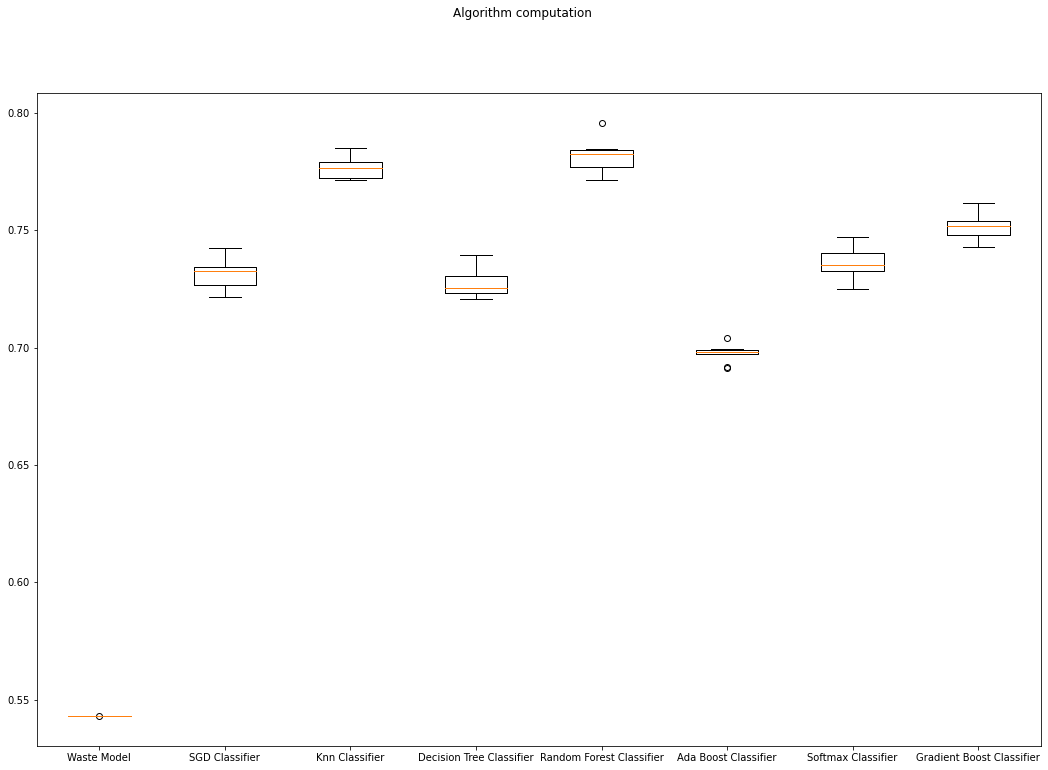

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(18,12))
fig.suptitle("Algorithm computation")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [5]:
rf = RandomForestClassifier()
cross_val_score(rf, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring="accuracy")

array([0.77606061, 0.77919192, 0.77575758])

In [6]:
y_train_pred = cross_val_predict(rf, X_train, y_train, cv=StratifiedKFold(n_splits=3))

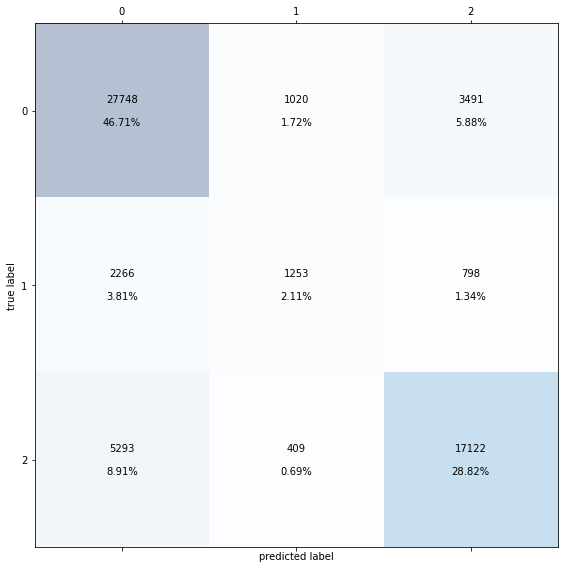

In [19]:
#Print the Confusion Matrix
conf_mx = confusion_matrix(y_train, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_mx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        perc = str(round((conf_mx[i, j]/conf_mx.sum())*100,2)) + "%"
        ax.text(x=j, y=i, s=str(conf_mx[i, j])+"\n\n"+perc, va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

**Trying to Optimize the Random Forest Model with Baeysian Optimization with gaussian process**

In [4]:
#Creating a optimize callable function to be fed to sklearn.gpminimize and it takes a single list of parameters and it returns a value
def optimize(params,param_names,x,y):
    params = dict(zip(param_names,params)) 
    model = RandomForestClassifier(**params) #It takes the params as parameter
    kf = StratifiedKFold(n_splits=5)
    accuracies = []
    
    return -np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=3),n_jobs=-1, scoring="accuracy"))

In [5]:
param_space = [
    space.Integer(30,60,name="max_depth"),
    space.Integer(100,300,name="n_estimators"),
    space.Categorical(["gini","entropy"],name="criterion"),
    space.Real(0.01,1,prior="uniform",name="max_features"),
    space.Integer(1,10,name="min_samples_leaf")
]
param_names = ["max_depth","n_estimators","criterion","max_features"]
optimization_function = partial(optimize,param_names= param_names,x = X_train,y = y_train)

In [6]:
result = gp_minimize(optimization_function,dimensions=param_space,n_calls=10,verbose=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 508.4996
Function value obtained: -0.7774
Current minimum: -0.7774
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1003.3217
Function value obtained: -0.7773
Current minimum: -0.7774
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 430.9926
Function value obtained: -0.7781
Current minimum: -0.7781
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 370.7828
Function value obtained: -0.7755
Current minimum: -0.7781
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 482.4592
Function value obtained: -0.7748
Current minimum: -0.7781
Iteration No: 

In [7]:
print("Best Score = %.4f" % result.fun)

Best Score = -0.7788


In [16]:
rf_params = dict(zip(param_names,result.x))
rf_params

{'max_depth': 52,
 'n_estimators': 271,
 'criterion': 'gini',
 'max_features': 0.5783538396142335}

In [58]:
pickle.dump(result, open('bayessian_optimization_rf.sav', 'wb'))

In [13]:
result.x

[52, 271, 'gini', 0.5783538396142335, 7]

#### SGD Classifier

In [9]:
sgd = SGDClassifier()
cross_val_score(sgd, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring="accuracy")

array([0.73186869, 0.73141414, 0.73282828])

In [10]:
y_train_pred = cross_val_predict(sgd, X_train, y_train, cv=3)

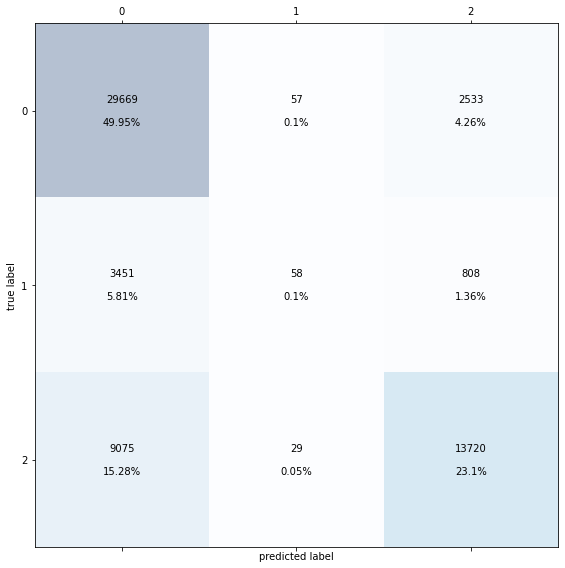

In [11]:
conf_mx = confusion_matrix(y_train, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_mx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        perc = str(round((conf_mx[i, j]/conf_mx.sum())*100,2)) + "%"
        ax.text(x=j, y=i, s=str(conf_mx[i, j])+"\n\n"+perc, va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

#### Trying to Optimize the SGD Model with Baeysian Optimization with gaussian process

In [36]:
def optimize_sgd(params,param_names,x,y):
    params = dict(zip(param_names,params)) 
    model = SGDClassifier(**params) #It takes the params as parameter
    kf = StratifiedKFold(n_splits=5)
    accuracies = []
    
    return -np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=3),n_jobs=-1, scoring="accuracy"))

In [37]:
param_space_sgd = [
    space.Categorical(["none","l2","l1","elasticnet"],name="penalty"),
    space.Real(0.00001,0.01,prior="log-uniform",name="alpha"),
    space.Categorical(["log"],name="loss")
]
param_names_sgd = ["penalty","alpha","loss"]
optimization_function = partial(optimize_sgd,param_names= param_names_sgd,x = X_train,y = y_train)

In [38]:
result = gp_minimize(optimization_function,dimensions=param_space_sgd,n_calls=10,verbose=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.8025
Function value obtained: -0.7352
Current minimum: -0.7352
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.4575
Function value obtained: -0.7357
Current minimum: -0.7357
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8462
Function value obtained: -0.7343
Current minimum: -0.7357
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.8818
Function value obtained: -0.7292
Current minimum: -0.7357
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9397
Function value obtained: -0.7355
Current minimum: -0.7357
Iteration No: 6 started. 

In [39]:
print("Best Score = %.4f" % result.fun)

Best Score = -0.7357


In [40]:
sgd_params = dict(zip(param_names_sgd,result.x))
sgd_params

{'penalty': 'none', 'alpha': 0.0034706435880870164, 'loss': 'log'}

In [24]:
pickle.dump(result, open('bayessian_optimization_sgd.sav', 'wb'))

#### KNN Classifier

In [25]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring="accuracy")

array([0.76717172, 0.76868687, 0.76641414])

In [26]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=3)

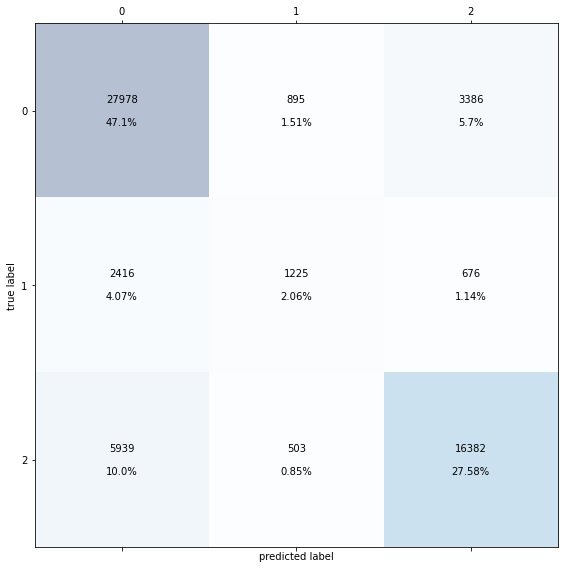

In [27]:
conf_mx = confusion_matrix(y_train, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_mx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        perc = str(round((conf_mx[i, j]/conf_mx.sum())*100,2)) + "%"
        ax.text(x=j, y=i, s=str(conf_mx[i, j])+"\n\n"+perc, va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

#### Trying to Optimize the KNN Model with Baeysian Optimization with gaussian process

In [29]:
def optimize_knn(params,param_names,x,y):
    params = dict(zip(param_names,params)) 
    model = KNeighborsClassifier(**params) #It takes the params as parameter
    return -np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=3),n_jobs=-1, scoring="accuracy"))

In [30]:
param_space_knn = [
    space.Categorical(['uniform', 'distance'],name="weights"),
    space.Integer(1,10,name="n_neighbors")
]
param_names_knn = ["weights","n_neighbors"]
optimization_function = partial(optimize_knn,param_names= param_names_knn,x = X_train,y = y_train)

In [31]:
result = gp_minimize(optimization_function,dimensions=param_space_knn,n_calls=10,verbose=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 62.1422
Function value obtained: -0.7715
Current minimum: -0.7715
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 54.1438
Function value obtained: -0.7697
Current minimum: -0.7715
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 32.1412
Function value obtained: -0.7585
Current minimum: -0.7715
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 58.0561
Function value obtained: -0.7703
Current minimum: -0.7715
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 58.2534
Function value obtained: -0.7678
Current minimum: -0.7715
Iteration No: 6 star

In [32]:
print("Best Score = %.4f" % result.fun)

Best Score = -0.7715


In [34]:
knn_params = dict(zip(param_names_knn,result.x))
knn_params

{'weights': 'distance', 'n_neighbors': 8}

In [42]:
pickle.dump(result, open('bayessian_optimization_knn.sav', 'wb'))

#### XGBoost Classifier

In [47]:
xg = xgboost.XGBClassifier()
cross_val_score(xg, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring="accuracy")

array([0.78439394, 0.78813131, 0.78242424])

In [49]:
y_train_pred = cross_val_predict(xg, X_train, y_train, cv=3)

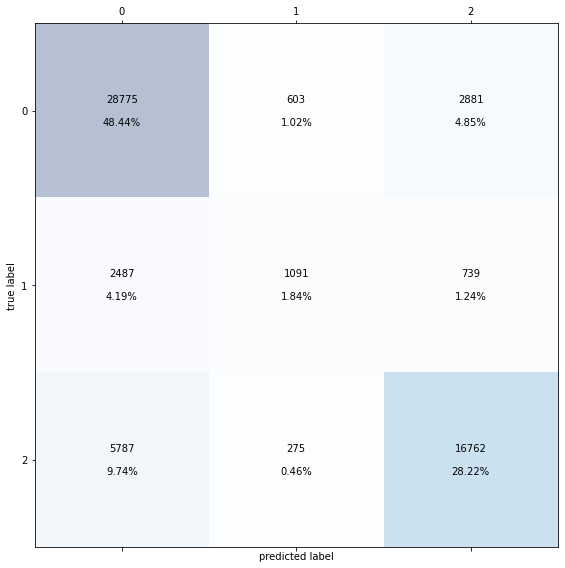

In [50]:
conf_mx = confusion_matrix(y_train, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_mx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        perc = str(round((conf_mx[i, j]/conf_mx.sum())*100,2)) + "%"
        ax.text(x=j, y=i, s=str(conf_mx[i, j])+"\n\n"+perc, va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

#### Trying to Optimize the XGboost Model with Baeysian Optimization with gaussian process

In [52]:
def optimize_xg(params,param_names,x,y):
    params = dict(zip(param_names,params)) 
    model = xgboost.XGBClassifier(**params) #It takes the params as parameter
    return -np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=3),n_jobs=-1, scoring="accuracy"))

In [54]:
param_space_xg = [
    space.Integer(50,300,name="n_estimators"),
    space.Integer(1,10,name="max_depth"),
    space.Real(0.0001,0.1,prior="log-uniform",name="learning_rate")
]
param_names_xg = ["n_estimators","max_depth","learning_rate"]
optimization_function = partial(optimize_xg,param_names= param_names_xg,x = X_train,y = y_train)

In [55]:
result = gp_minimize(optimization_function,dimensions=param_space_xg,n_calls=10,verbose=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 149.4969
Function value obtained: -0.6625
Current minimum: -0.6625
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 69.4157
Function value obtained: -0.6708
Current minimum: -0.6708
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 408.8701
Function value obtained: -0.7678
Current minimum: -0.7678
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 356.7607
Function value obtained: -0.6957
Current minimum: -0.7678
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 352.9683
Function value obtained: -0.7362
Current minimum: -0.7678
Iteration No: 6 

In [56]:
print("Best Score = %.4f" % result.fun)

Best Score = -0.7723


In [58]:
xgb_params = dict(zip(param_names_xg,result.x))
xgb_params

{'n_estimators': 247, 'max_depth': 5, 'learning_rate': 0.046119524684849804}

In [59]:
pickle.dump(result, open('bayessian_optimization_xgb.sav', 'wb'))

XG perfomed better than Random Forest

Putting all the models in an ensemble model and run a voting classifier

In [9]:
sgd_classifier = SGDClassifier(**sgd_params)
rnd_classifier = RandomForestClassifier(**rf_params)
knn_classifier = KNeighborsClassifier(**knn_params)
log_classifier = LogisticRegression(multi_class="multinomial",solver="lbfgs",C= 30, n_jobs=-1)
dtr_classifier = DecisionTreeClassifier(max_depth= 20, min_samples_split= 10)
ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=200, algorithm="SAMME.R", 
                             learning_rate=0.5)
gbrt_classifier = GradientBoostingClassifier(max_depth=5, n_estimators=500, learning_rate=0.5)
xgb_classifier = xgboost.XGBClassifier(**xgb_params)

clf_list = [sgd_classifier,rnd_classifier,knn_classifier,log_classifier,dtr_classifier,ada_classifier,gbrt_classifier,xgb_classifier]

In [10]:
voting_cls = VotingClassifier(
    estimators=[('SGD Classifier', clf_list[0]), 
                ('Random Forests', clf_list[1]),
                ('k-Nearest Neighbors', clf_list[2]), 
                ('Softmax Regression', clf_list[3]),
                ('Decission Trees', clf_list[4]), 
                ('AdaBoost', clf_list[5]),
                ('Gradient Boost', clf_list[6]), 
                ('XGBoost', clf_list[7])], 
                voting='hard', n_jobs=-1)
voting_cls.fit(X_train, y_train)

VotingClassifier(estimators=[('SGD Classifier',
                              SGDClassifier(alpha=0.0034706435880870164,
                                            average=False, class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='none',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validat...
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan

In [14]:
cv_results = cross_validate(voting_cls, X_train, y_train, cv = 3, scoring="accuracy")
cv_results['test_score'].mean()

0.7847474747474749

In [15]:
pickle.dump(voting_cls, open('voting_cls.sav', 'wb'))

#### Stacking 

In [16]:
X_train.shape

(59400, 100)

In [17]:
shuf_idx = np.random.permutation(len(X_train))

#Splitting into train,test,validation
Xtr = X_train[shuf_idx[:33000]]
ytr = y_train[shuf_idx[:33000]]
# validation set
Xvl = X_train[shuf_idx[33000:46200]]
yvl = y_train[shuf_idx[33000:46200]]
# test set
Xts = X_train[shuf_idx[46200:]]
yts = y_train[shuf_idx[46200:]]

Xtr.shape, Xvl.shape, Xts.shape

((33000, 100), (13200, 100), (13200, 100))

In [20]:
#Fitting the training set to all the classifiers in the clf_list
for i,clf in enumerate(clf_list):
    clf.fit(Xtr,ytr)
    print("Fitted {}/{}".format(i+1,len(clf_list)))

Fitted 1/8
Fitted 2/8
Fitted 3/8
Fitted 4/8
Fitted 5/8
Fitted 6/8
Fitted 7/8
Fitted 8/8


In [21]:
# run individual classifiers on val set
yhat = {}
for i, clf in enumerate(clf_list):
    yhat[i] = clf.predict(Xvl)
    print("Predicted {}/{}".format(i+1,len(clf_list)))

Predicted 1/8
Predicted 2/8
Predicted 3/8
Predicted 4/8
Predicted 5/8
Predicted 6/8
Predicted 7/8
Predicted 8/8


In [22]:
# create new training set from predictions
# combine the predictions into vectors using a horizontal stacking
Xblend = np.c_[[preds for preds in yhat.values()]].T

In [23]:
#Transform labels into codes
le = preprocessing.LabelEncoder()
Xblend = le.fit_transform(Xblend.reshape(13200*8)).reshape(13200,8)

In [24]:
# train a random forest classifier on Xblend using yvl for target labels
rf_blend = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_blend.fit(Xblend, yvl)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [25]:
cv_results = cross_validate(rf_blend, Xblend, yvl, cv = 3, scoring="accuracy")

pickle.dump(rf_blend, open('rf_blend.sav', 'wb'))

cv_results['test_score'].mean()

0.7805303030303031

In [26]:
# run individual classifiers on test set
yhatts = {}
for i, clf in enumerate(clf_list):
    yhatts[i] = clf.predict(Xts)
    print("Predicted {}/{}".format(i+1,len(clf_list)))

Predicted 1/8
Predicted 2/8
Predicted 3/8
Predicted 4/8
Predicted 5/8
Predicted 6/8
Predicted 7/8
Predicted 8/8


In [27]:
Xblendts = np.c_[[preds for preds in yhatts.values()]].T

Xblendts = le.transform(Xblendts.reshape(13200*8)).reshape(13200,8)

cv_results = cross_validate(rf_blend, Xblendts, yts, cv = 3, scoring="accuracy")
cv_results['test_score'].mean()

0.7788636363636364

## Ensembling Random Forest and XGBoost

In [29]:
rnd_clf = RandomForestClassifier(**rf_params)
xgb_clf = xgboost.XGBClassifier(**xgb_params)

clf_rfx = [rnd_clf,xgb_clf]

In [30]:
voting_clf_ens_rfxgb = VotingClassifier(
    estimators=[('Random Forests', clf_rfx[0]),
                ('XGBoost', clf_rfx[1])], 
                voting='soft', n_jobs=-1)
voting_clf_ens_rfxgb.fit(X_train, y_train)

VotingClassifier(estimators=[('Random Forests',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=52,
                                                     max_features=0.5783538396142335,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fract

In [32]:
cv_results = cross_validate(voting_clf_ens_rfxgb, X_train, y_train, cv = 3, scoring="accuracy")
cv_results['test_score'].mean()

0.7873737373737373

In [33]:
pickle.dump(voting_clf_ens_rfxgb, open('voting_clf_ens_rfxgb.sav', 'wb'))

#### Stacking Random Forest and XGBoost

In [34]:
idx = np.random.permutation(len(X_train))  # create shuffle index

## split into three sets
# training set
Xtr = X_train[idx[:33000]]
ytr = y_train[idx[:33000]]
# validation set
Xvl = X_train[idx[33000:46200]]
yvl = y_train[idx[33000:46200]]
# test set
Xts = X_train[idx[46200:]]
yts = y_train[idx[46200:]]

Xtr.shape, Xvl.shape, Xts.shape

((33000, 100), (13200, 100), (13200, 100))

In [35]:
for i, clf in enumerate(clf_rfx):
    clf.fit(Xtr, ytr)
    print("Fitted {}/{}".format(i+1,len(clf_rfx )))

Fitted 1/2
Fitted 2/2


In [41]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.046119524684849804, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=247, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# run individual classifiers on val set
yhat = {}
for i, clf in enumerate(clf_rfx):
    yhat[i] = clf.predict(Xvl)
    print("Predicted {}/{}".format(i+1,len(clf_rfx)))

Predicted 1/2
Predicted 2/2


In [40]:
yhat

{0: array(['functional', 'functional', 'non functional', ..., 'functional',
        'non functional', 'non functional'], dtype=object),
 1: array(['functional', 'functional', 'non functional', ..., 'functional',
        'non functional', 'non functional'], dtype=object)}

In [37]:
# create new training set from predictions
# combine the predictions into vectors using a horizontal stacking
Xblend = np.c_[[preds for preds in yhat.values()]].T

In [38]:
#Transform labels into codes
le = preprocessing.LabelEncoder()
Xblend = le.fit_transform(Xblend.reshape(13200*2)).reshape(13200,2)

In [44]:
# train a random forest classifier on Xblend using yvl for target labels
rf_blend = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf_blend.fit(Xblend, yvl)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [45]:
cv_results = cross_validate(rf_blend, Xblend, yvl, cv = 3, scoring="accuracy")

pickle.dump(rf_blend, open('rf_blend.sav', 'wb'))

cv_results['test_score'].mean()

0.7731060606060606

In [46]:
#Lets see how it performs on unseen data
# run individual classifiers on test set
yhatts = {}
for i, clf in enumerate(clf_rfx):
    yhatts[i] = clf.predict(Xts)
    print("Predicted {}/{}".format(i+1,len(clf_rfx)))

Predicted 1/2
Predicted 2/2


In [47]:
Xblendts = np.c_[[preds for preds in yhatts.values()]].T

Xblendts = le.transform(Xblendts.reshape(13200*2)).reshape(13200,2)

cv_results = cross_validate(rf_blend, Xblendts, yts, cv = 3, scoring="accuracy")
cv_results['test_score'].mean()

0.7784848484848484

#### Submisssion 

In [50]:
submission_fr.head(10)

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label
5,52449,predicted label
6,24806,predicted label
7,28965,predicted label
8,36301,predicted label
9,54122,predicted label


In [48]:
preds = voting_clf_ens_rfxgb.predict(X_test)

In [49]:
preds.shape

(14850,)

In [51]:
submission = pd.DataFrame({'id': submission_fr["id"],'status_group': preds})
submission.to_csv('submission.csv', index=False)